In [1]:
from melodies_monet import driver

/home/charkins/miniconda3/envs/melodies-monet_aircraft/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


### Driver class

Now lets create an instance of the python driver analysis class. It consists of 4 main parts; model instances, observation instances, a paired instance of both. This will allow us to move things around the plotting function for spatial and overlays and more complex plots.


In [2]:
control_fn='control_wrfchem_aircraft_sumpmspecies.yaml'
an = driver.analysis()
an.control=control_fn
an.read_control() 
an.control_dict  

{'analysis': {'start_time': '2019-09-05-12:00:00',
  'end_time': '2019-09-06-00:00:00',
  'output_dir': '/wrk/charkins/melodies_monet/aircraft/develop_sumvars/output',
  'debug': True},
 'model': {'wrfchem_v4.2': {'files': '/wrk/users/charkins/melodies-monet_data/wrfchem/run_CONUS_fv19_BEIS_1.0xISO_RACM_v4.2.2_racm_berk_vcp_noI_phot_soa/0905/*',
   'mod_type': 'wrfchem',
   'mod_kwargs': {'mech': 'racm_esrl_vcp'},
   'radius_of_influence': 12000,
   'mapping': {'firexaq': {'oa_tot': 'OA_PM1_AMS_JIMENEZ',
     'SO4A': 'Sulfate_PM1_AMS_JIMENEZ',
     'NH4A': 'Ammonium_PM1_AMS_JIMENEZ',
     'NO3A': 'Nitrate_PM1_AMS_JIMENEZ',
     'EC': 'BC_mass_90_550_nm_SCHWARZ'}},
   'variables': {'pres_pa_mid': {'rename': 'pressure_model',
     'unit_scale': 1,
     'unit_scale_method': '*'},
    'temperature_k': {'rename': 'temp_model',
     'unit_scale': 1,
     'unit_scale_method': '*'}},
   'variable_summing': {'oa_tot': {'vars': ['orgpai',
      'orgpaj',
      'asoa1i',
      'asoa1j',
      'as

### Loading the model data

driver will automatically loop through the "models" found in the model section of the yaml file and create an instance of the driver.model class for each that includes the label, mapping information, and xarray object as well as the filenames. Note it can open multiple files easily by including hot keys 

In [3]:
an.open_models()

NOTE: model.wrfchem_v4.2.projection is 'None' (str), but we assume you want `None` (Python null sentinel). To avoid this warning, update your control file to remove the projection setting or set to `~` or `null` if you want null value in YAML.
wrfchem
/wrk/users/charkins/melodies-monet_data/wrfchem/run_CONUS_fv19_BEIS_1.0xISO_RACM_v4.2.2_racm_berk_vcp_noI_phot_soa/0905/*
**** Reading WRF-Chem model output...


In [4]:
an.models['wrfchem_v4.2'].obj

<xarray.Dataset>
Dimensions:         (y: 284, x: 440, time: 31, z: 50)
Coordinates:
    longitude       (y, x) float32 -122.3 -122.2 -122.1 ... -60.68 -60.52 -60.37
    latitude        (y, x) float32 21.19 21.22 21.24 21.27 ... 50.28 50.24 50.2
  * time            (time) datetime64[ns] 2019-09-05 ... 2019-09-06T06:00:00
Dimensions without coordinates: y, x, z
Data variables: (12/36)
    nh4ai           (time, z, y, x) float32 0.01599 0.016 ... 9.37e-05 9.374e-05
    so4ai           (time, z, y, x) float32 0.05252 0.05254 ... 0.0002829
    bsoa4j          (time, z, y, x) float32 1.181e-16 1.182e-16 ... 1.402e-15
    asoa4j          (time, z, y, x) float32 6.167e-10 6.163e-10 ... 4.61e-16
    orgpai          (time, z, y, x) float32 0.0005077 0.0005082 ... 1.042e-14
    nh4aj           (time, z, y, x) float32 0.2267 0.2267 ... 9.586e-05
    ...              ...
    surfpres_pa     (time, y, x) float32 1.008e+05 1.008e+05 ... 1.007e+05
    oa_tot          (time, z, y, x) float32 0.01354 0.01355 ... 4.639e-08
    SO4A            (time, z, y, x) float32 0.7969 0.7971 ... 0.01461 0.01461
    NH4A            (time, z, y, x) float32 0.2426 0.2427 ... 0.0001896
    NO3A            (time, z, y, x) float32 2.362e-16 2.363e-16 ... 0.0001896
    EC              (time, z, y, x) float32 0.01193 0.01193 ... 1.013e-12
Attributes: (12/15)
    FieldType:                 104
    MemoryOrder:               XYZ
    description:               Ammonium  conc. Aitken mode
    units:                     ug/kg-dryair
    stagger:                   
    coordinates:               XLONG XLAT XTIME
    ...                        ...
    MOAD_CEN_LAT:              39.617638
    STAND_LON:                 -97.0
    MAP_PROJ:                  1
    CEN_LAT:                   39.617638
    CEN_LON:                   -97.77487
    mapping_tables_to_airnow:  {'OZONE': 'o3', 'PM2.5': 'PM2_5_DRY', 'PM10': ...

In the control file, among others, we have directed the variables 'so4aj' and 'so4ai' to be summed into the variable 'SO4A'. The results confirming this can be seen below.

In [5]:
an.models['wrfchem_v4.2'].obj['so4aj'].sum(dim=['time','z','y','x']) + an.models['wrfchem_v4.2'].obj['so4ai'].sum(dim=['time','z','y','x'])

<xarray.DataArray ()>
array(59125664., dtype=float32)

In [6]:
an.models['wrfchem_v4.2'].obj['SO4A'].sum(dim=['time','z','y','x'])

<xarray.DataArray 'SO4A' ()>
array(59125640., dtype=float32)

### Open Obs

Now for monet-analysis we will open preprocessed data in either netcdf icartt or some other format. We will not be retrieving data like monetio does for some observations (ie aeronet, airnow, etc....). Instead we will provide utitilies to do this so that users can add more data easily.

Like models we list all obs objects in the yaml file and it will loop through and create driver.observation instances that include the model type, file, objects (i.e. data object) and label 

In [7]:
an.open_obs()

/home/charkins/miniconda3/envs/melodies-monet_aircraft/lib/python3.9/site-packages/xarray/core/groupby.py:534: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index_grouper = pd.Grouper(


In [8]:
an.obs['firexaq'].obj

<xarray.Dataset>
Dimensions:                                       (time: 35)
Coordinates:
  * time                                          (time) datetime64[ns] 2019-...
Data variables: (12/642)
    Time_Stop                                     (time) float64 6.35e+04 ......
    Day_Of_Year_YANG                              (time) float64 248.0 ... 248.0
    latitude                                      (time) float64 38.73 ... 34.63
    longitude                                     (time) float64 -97.65 ... -...
    altitude                                      (time) float64 894.7 ... 770.1
    HAE_GPS_Altitude_YANG                         (time) float64 868.9 ... 736.1
    ...                                            ...
    smoke_age_HOLMES                              (time) float64 nan nan ... nan
    smoke_age_corr_HOLMES                         (time) float64 nan nan ... nan
    smoke_age_rise_HOLMES                         (time) float64 nan nan ... nan
    smoke_rise_HOLMES                             (time) float64 nan nan ... nan
    fire_distance_HOLMES                          (time) float64 nan nan ... nan
    smoke_agemethod_HOLMES                        (time) float64 nan nan ... nan
Attributes: (12/23)
    source:               Merged Flight#20190905, on the DC8 platform. Data i...
    Date Revised:         2022-02-11 00:00:00
    mission:              FIREXAQ
    organization:         NASA Langley Research Center
    PI:                   Suborbital Science Data for Atmospheric Composition
    PI_CONTACT_INFO:      gao.chen@nasa.gov, michael.shook@nasa.gov, ali.a.ak...
    ...                   ...
    PROJECT_INFO:         FIREXAQ
    STIPULATIONS_ON_USE:  N/A
    OTHER_COMMENTS:       This merge was created using the SSD-AC online merg...
    REVISION:             R1
    R1:                   File generated from data submitted before 2022, 2, ...
    R0:                   File was generated using the online merge tool.

### Variable transformations from std to amb

For several of the firexaq variables, we must convert the values from std to amb. This can be achieved with the melodies-monet tools melodies_monet.util.tools.convert_std_to_amb_ams() and melodies_monet.util.tools.convert_std_to_amb_bc(). 

This is shown below. The dataset is provided directly to the function and modified such that the dataset will contain the converted values. The units of the temperature variable must be K and the units of the pressure variable must be Pa.

In [9]:
an.obs['firexaq'].obj['OA_PM1_AMS_JIMENEZ'].sum(dim=['time'])

<xarray.DataArray 'OA_PM1_AMS_JIMENEZ' ()>
array(204.8938978)

In [10]:
from melodies_monet.util.tools import convert_std_to_amb_ams

In [11]:
convert_std_to_amb_ams(an.obs['firexaq'].obj,convert_vars=['OA_PM1_AMS_JIMENEZ','Sulfate_PM1_AMS_JIMENEZ','Ammonium_PM1_AMS_JIMENEZ',
                                                   'Nitrate_PM1_AMS_JIMENEZ'],temp_var='temp_obs',pres_var='pressure_obs')

In [13]:
from melodies_monet.util.tools import convert_std_to_amb_bc

In [14]:
convert_std_to_amb_bc(an.obs['firexaq'].obj,convert_vars=['BC_mass_90_550_nm_SCHWARZ'],temp_var='temp_obs',pres_var='pressure_obs')

In [15]:
an.obs['firexaq'].obj['OA_PM1_AMS_JIMENEZ'].sum(dim=['time'])

<xarray.DataArray 'OA_PM1_AMS_JIMENEZ' ()>
array(159.06208893)

In [16]:
an.pair_data()

After pairing:      Time_Stop  Day_Of_Year_YANG   latitude                time   longitude  \
0     63500.0             248.0  38.734977 2019-09-05 17:30:00  -97.653676   
1     63910.0             248.0  38.677687 2019-09-05 17:40:00  -98.239499   
2     64510.0             248.0  38.499000 2019-09-05 17:50:00  -99.550963   
3     65110.0             248.0  38.250739 2019-09-05 18:00:00 -101.083832   
4     65710.0             248.0  37.963158 2019-09-05 18:10:00 -102.715195   
5     66310.0             248.0  37.645989 2019-09-05 18:20:00 -104.370251   
6     66910.0             248.0  37.418731 2019-09-05 18:30:00 -105.996288   
7     67510.0             248.0  37.601763 2019-09-05 18:40:00 -107.633907   
8     68110.0             248.0  37.807663 2019-09-05 18:50:00 -109.295016   
9     68710.0             248.0  37.989196 2019-09-05 19:00:00 -110.938352   
10    69310.0             248.0  38.123925 2019-09-05 19:10:00 -112.295670   
11    70510.0             248.0  38.368578 2019-

Value of fill after reading from scatter_density_config: True
Processing scatter density plot for model 'wrfchem_v4.2' and observation 'firexaq'...


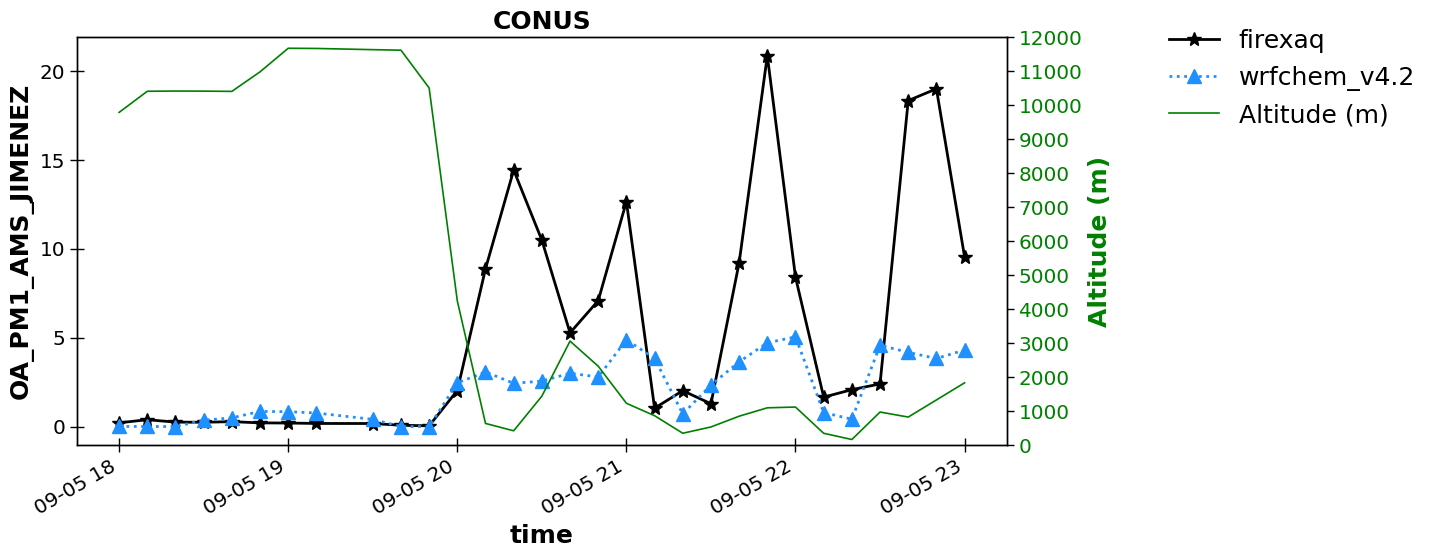

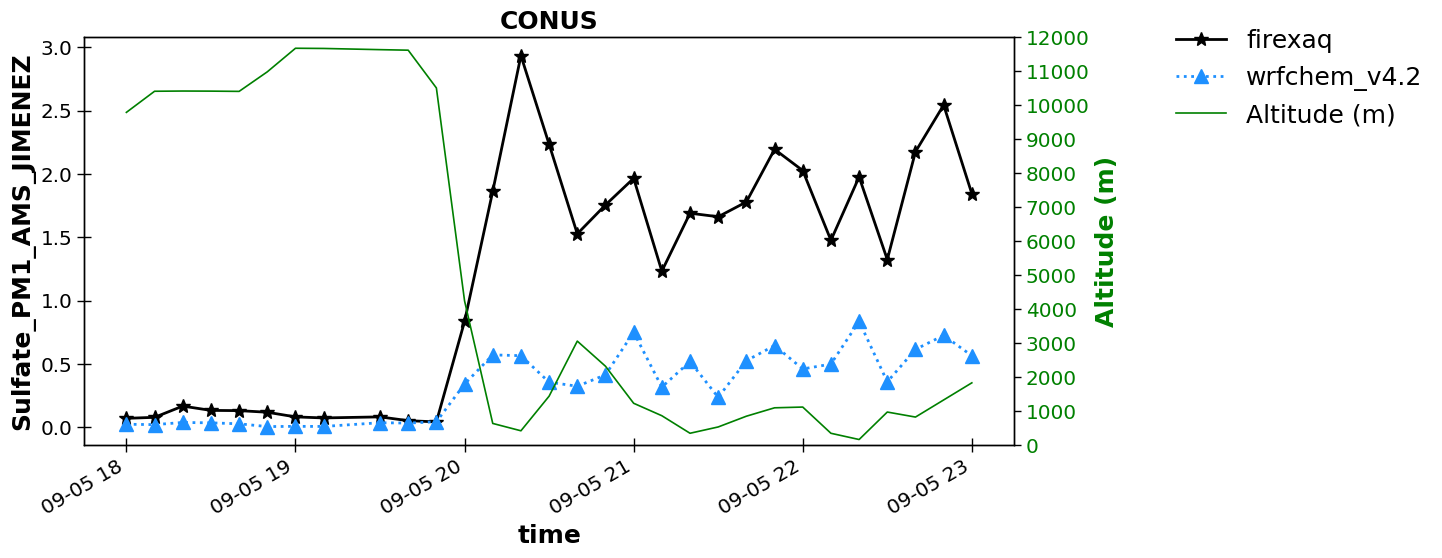

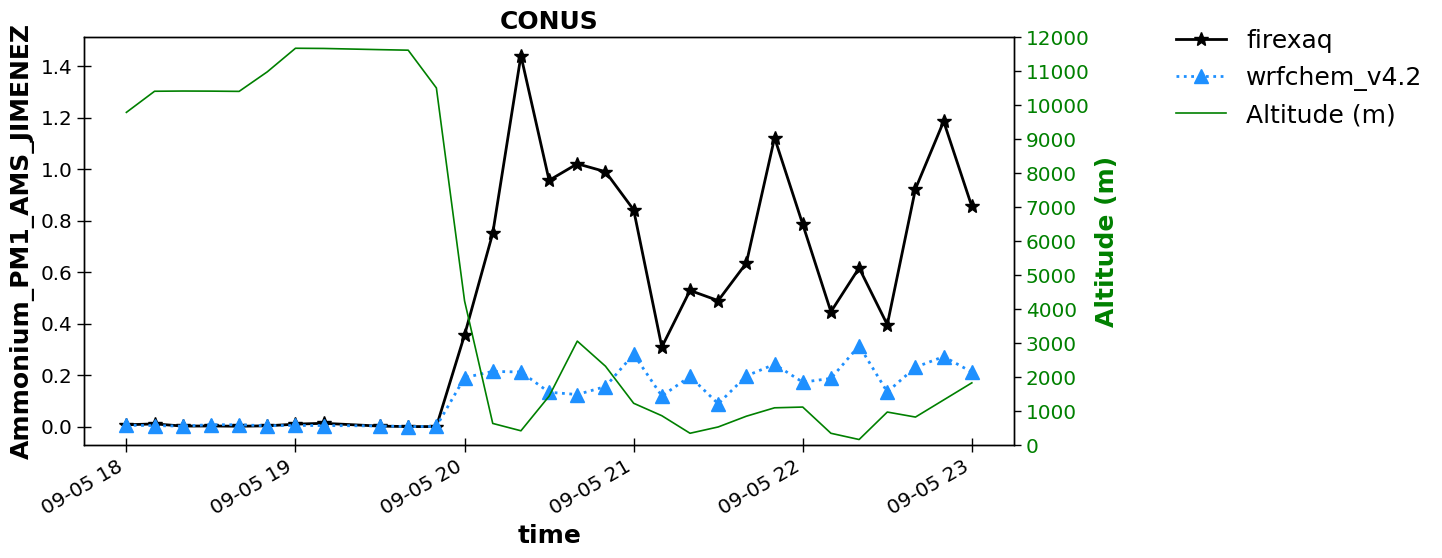

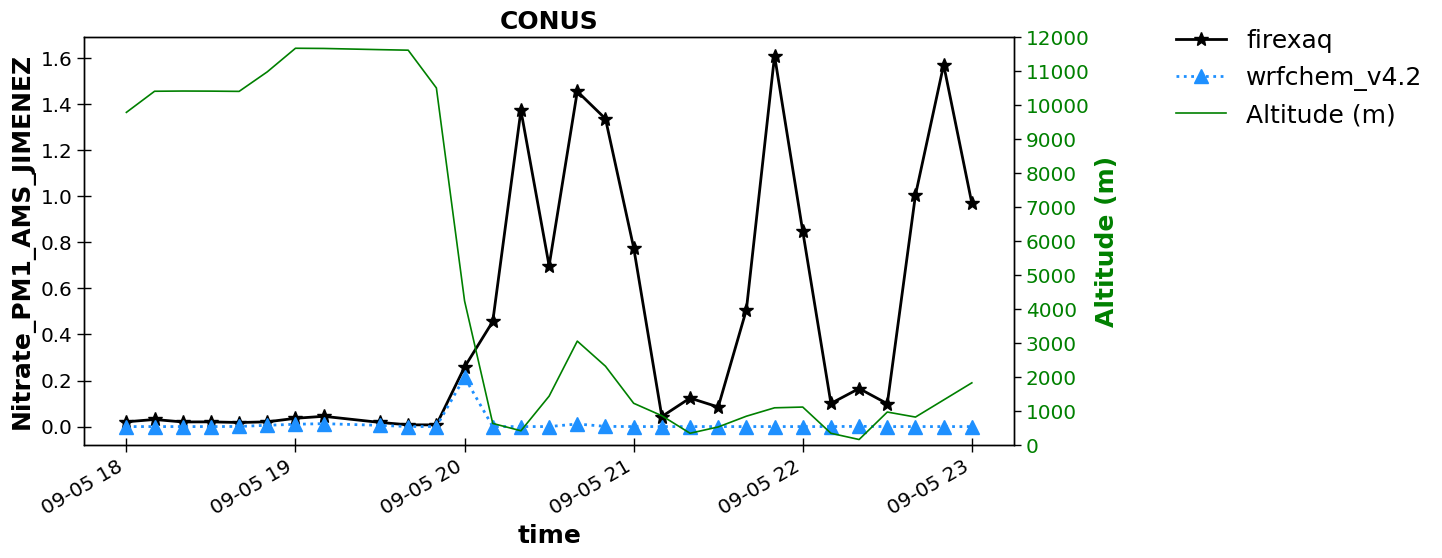

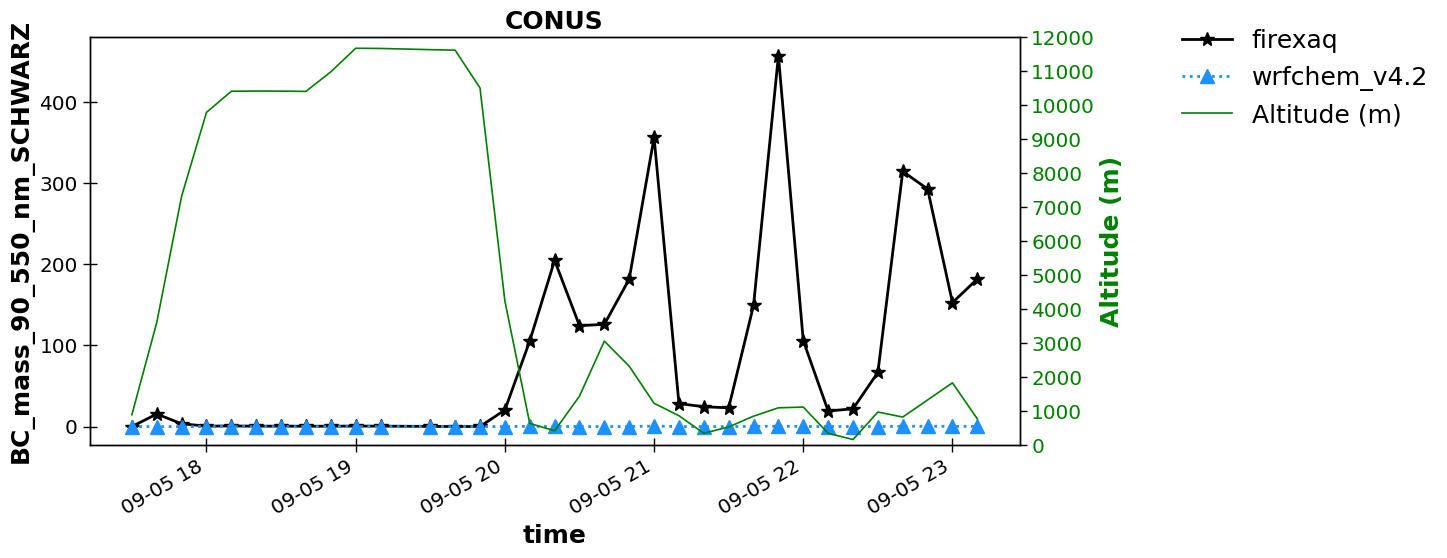

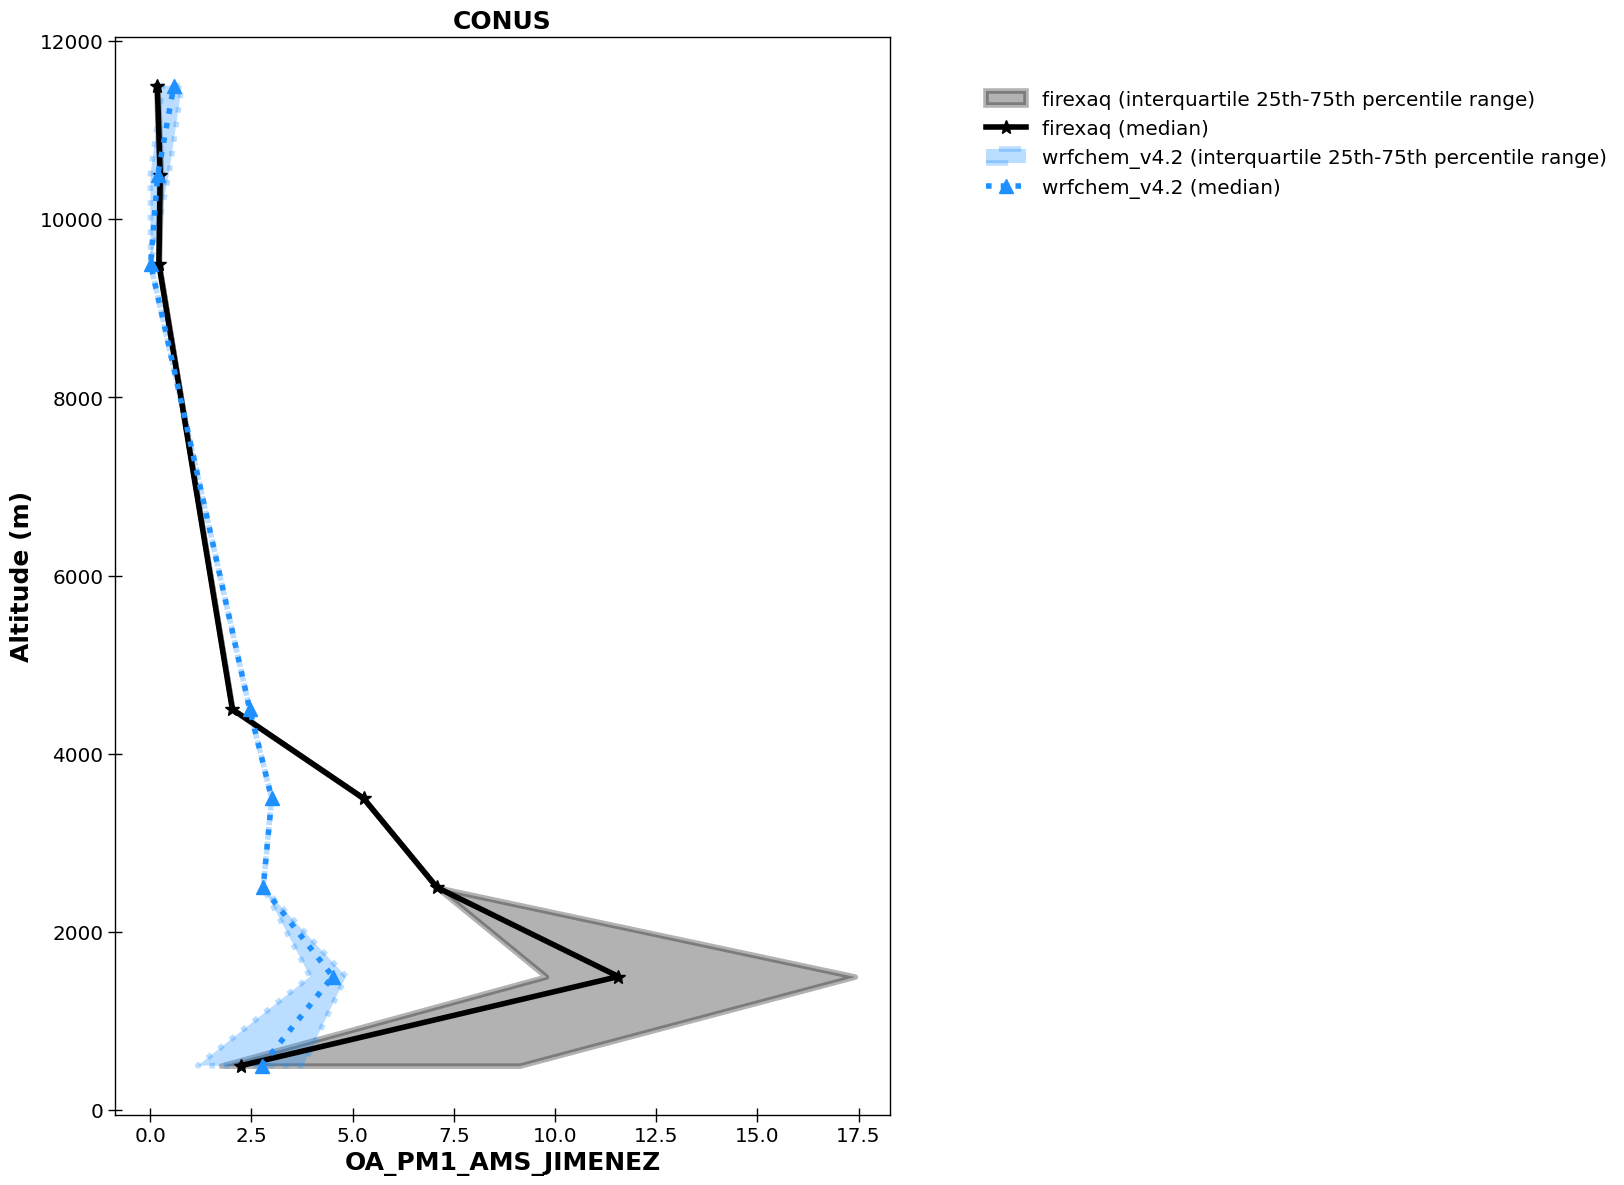

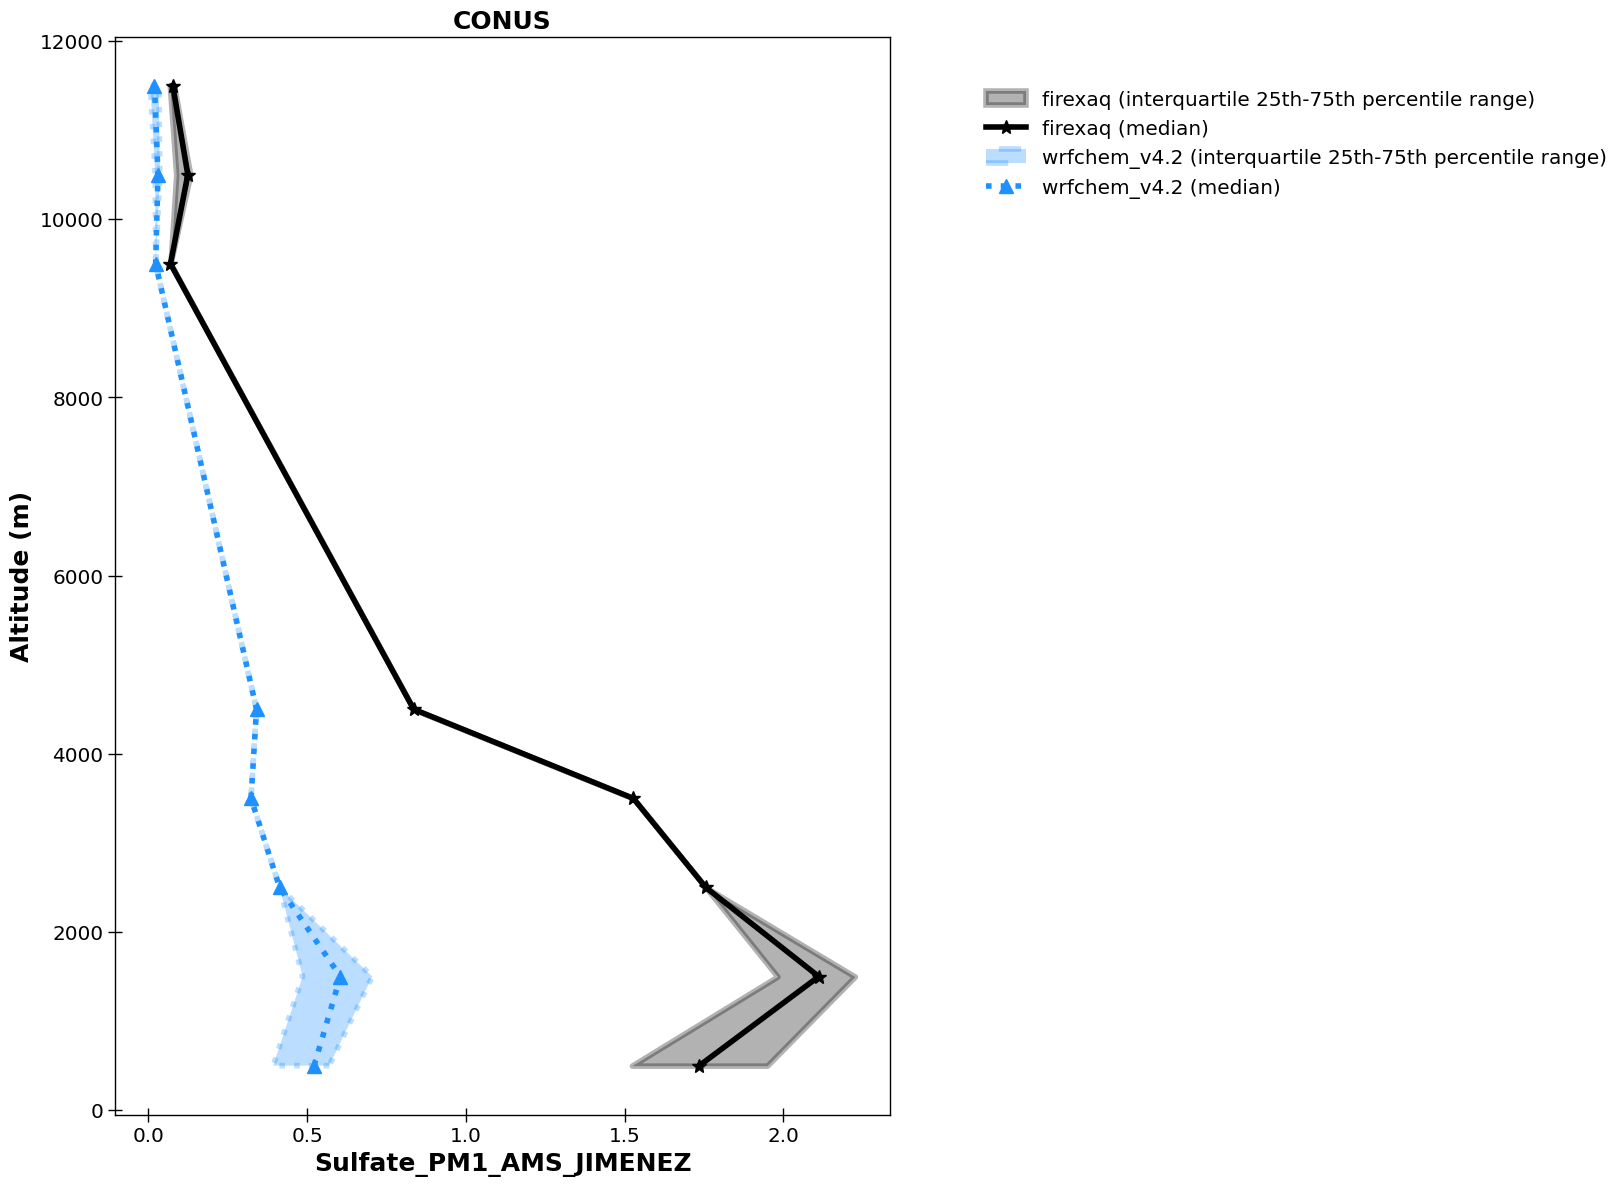

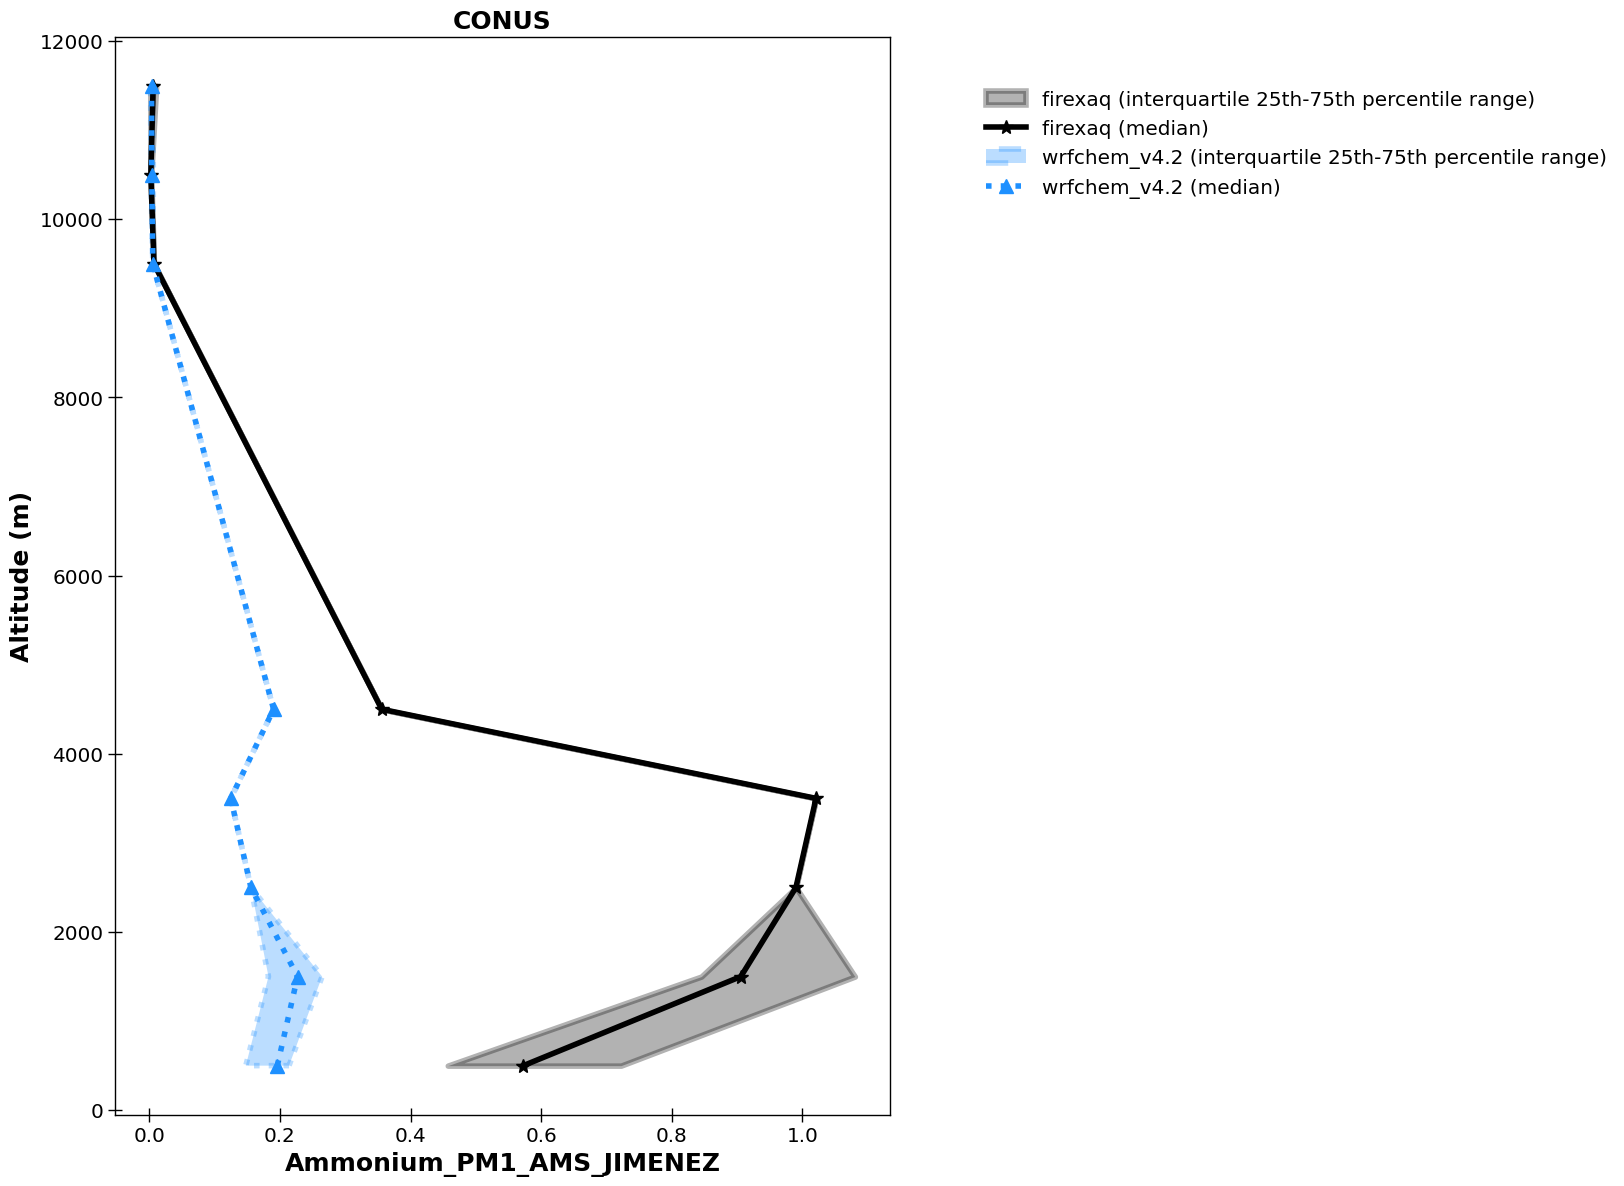

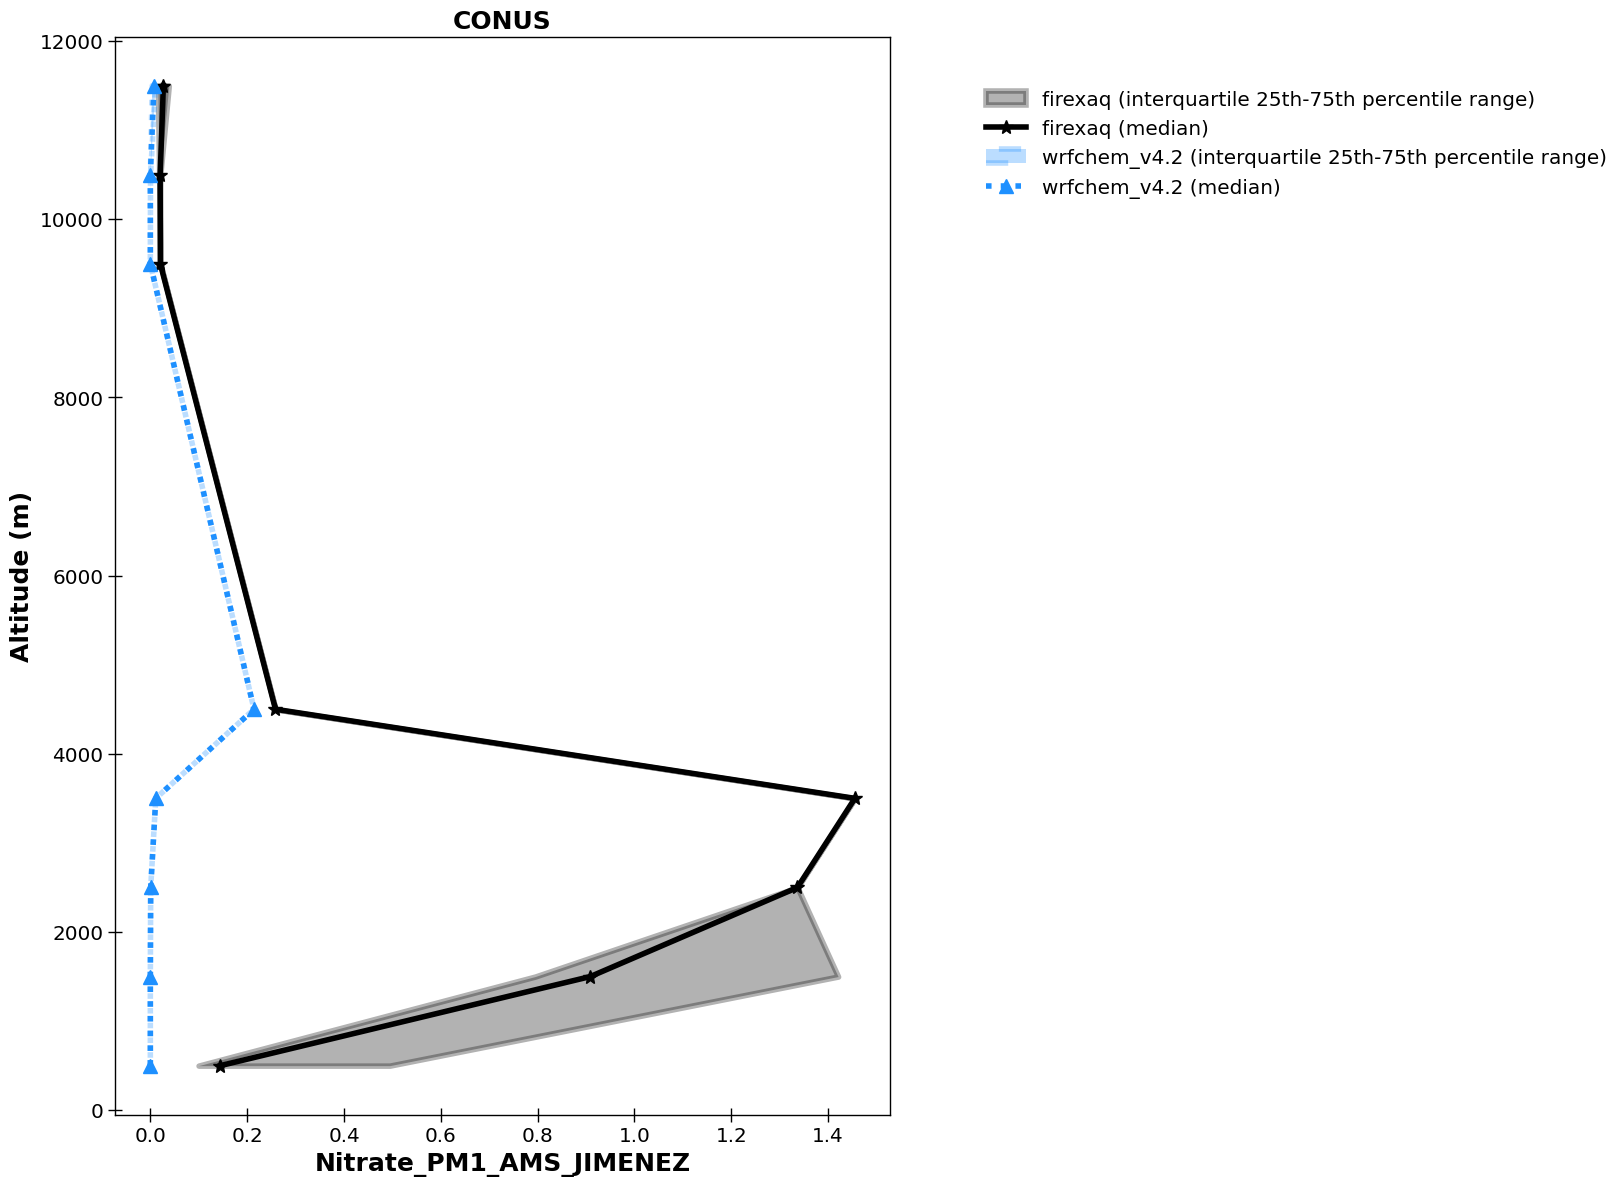

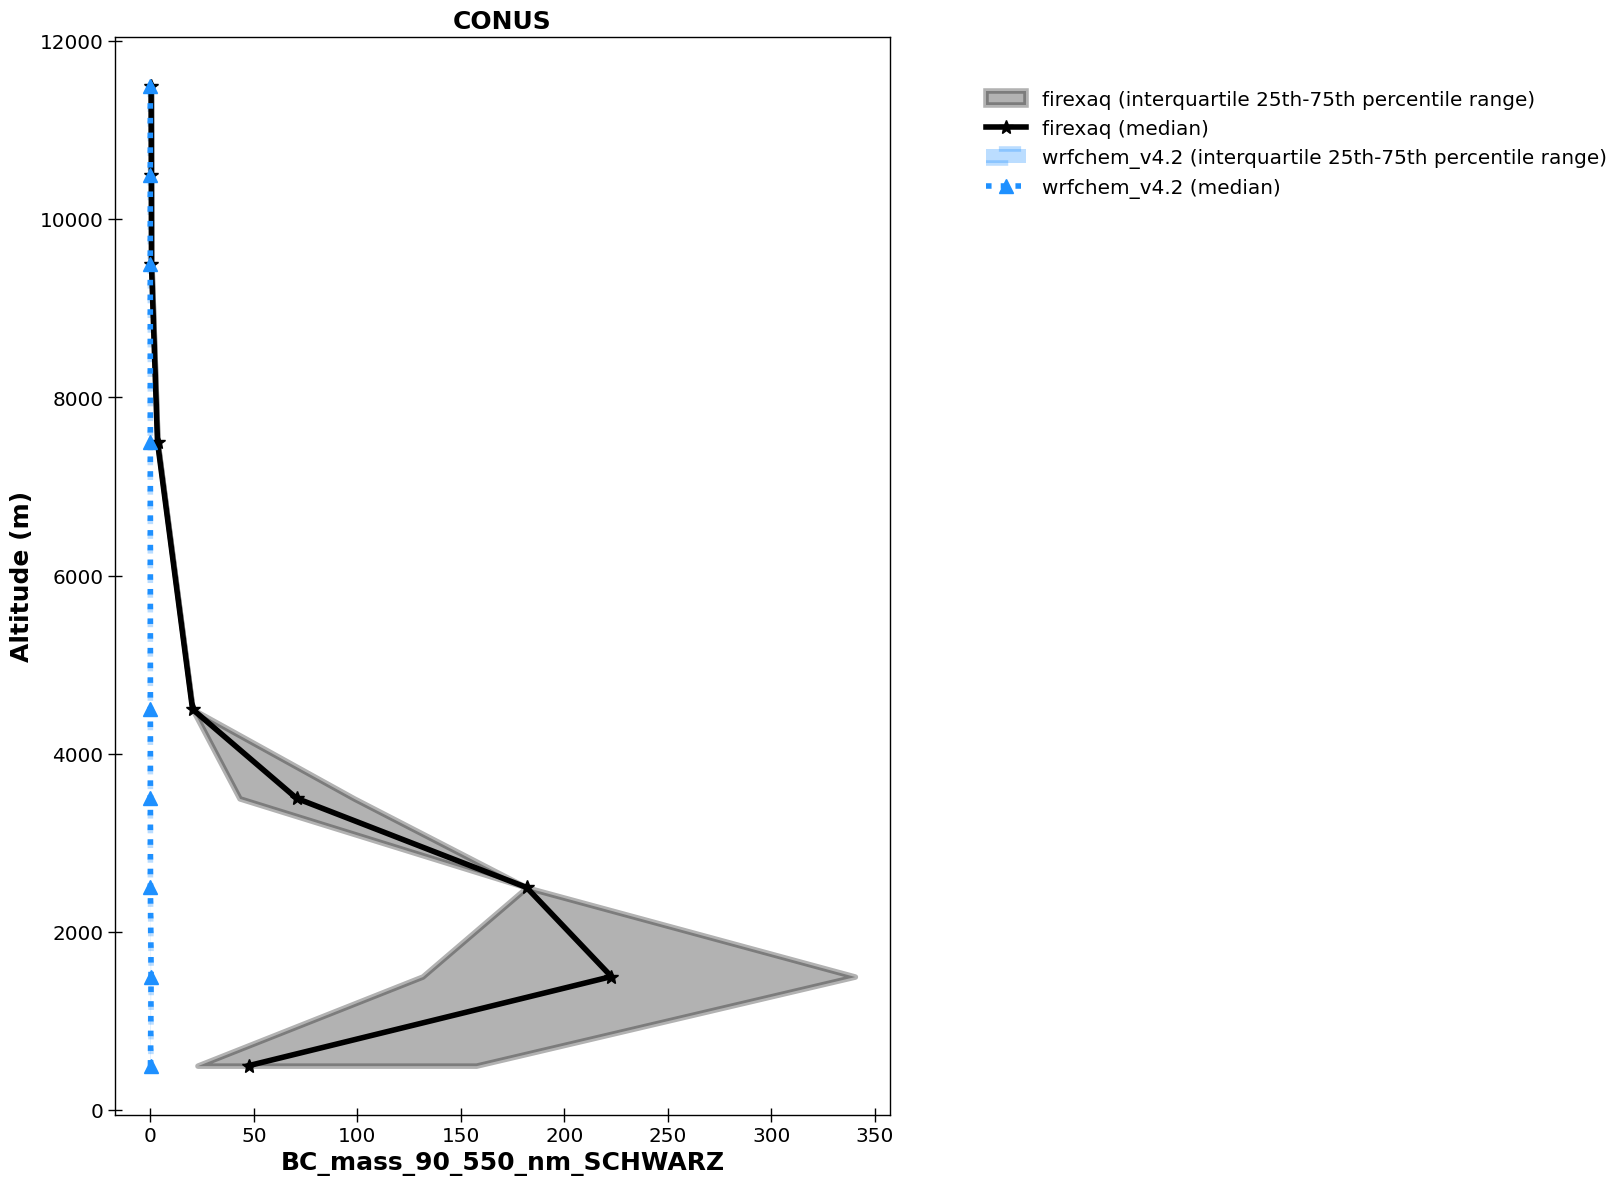

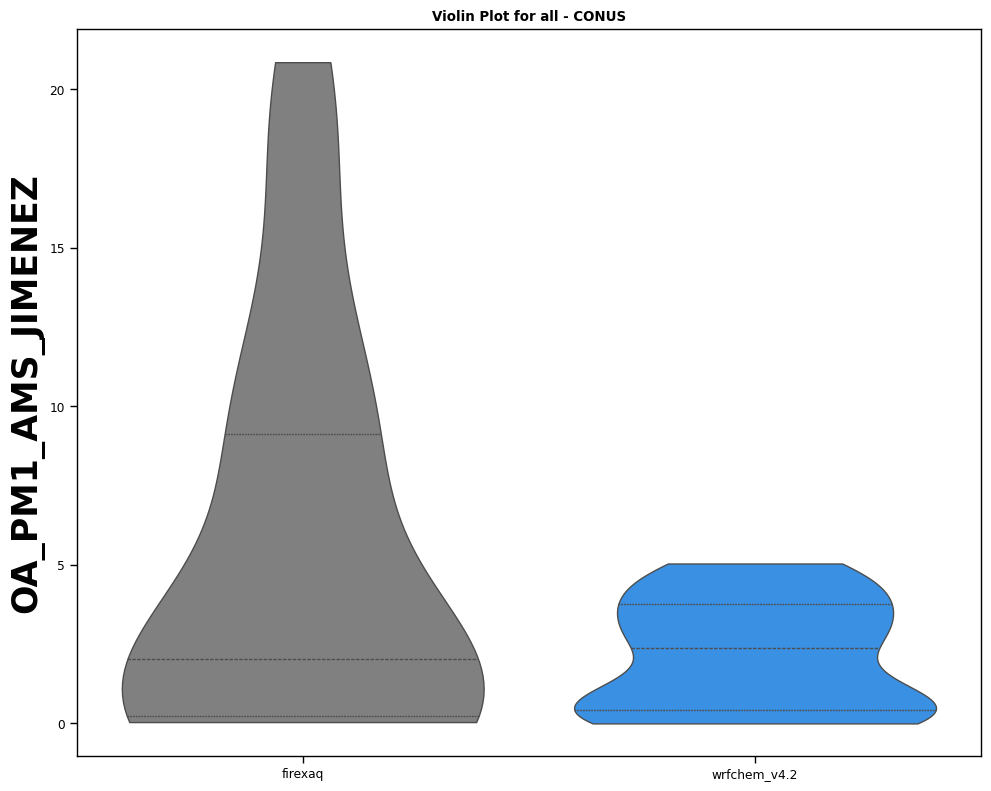

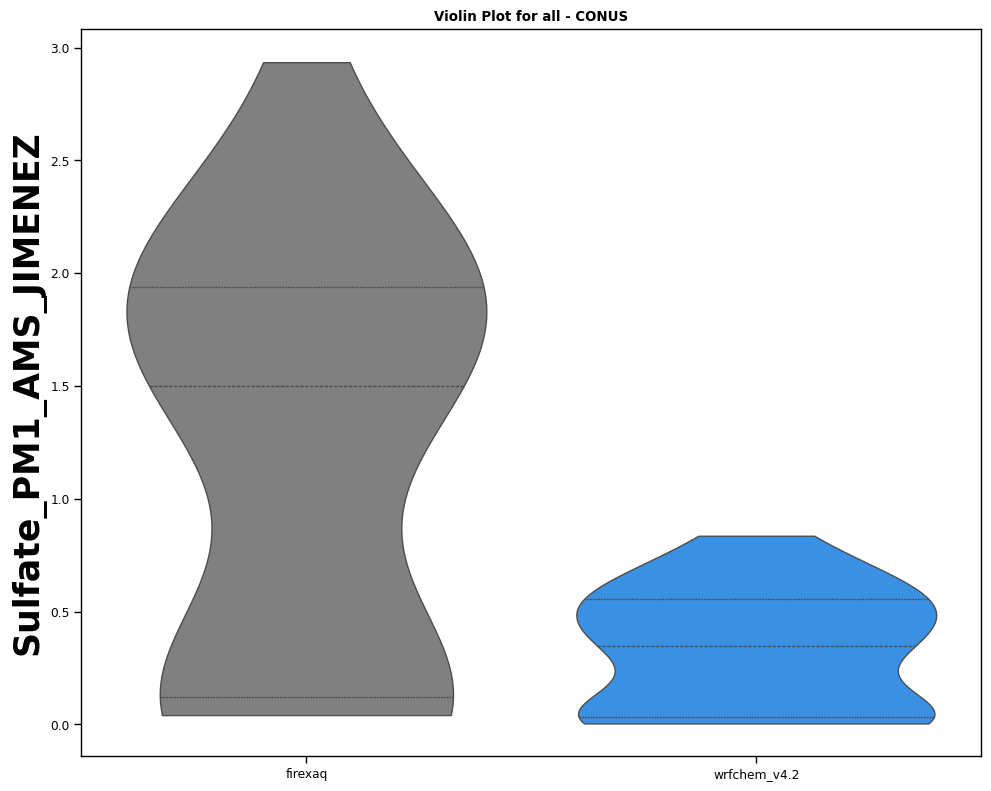

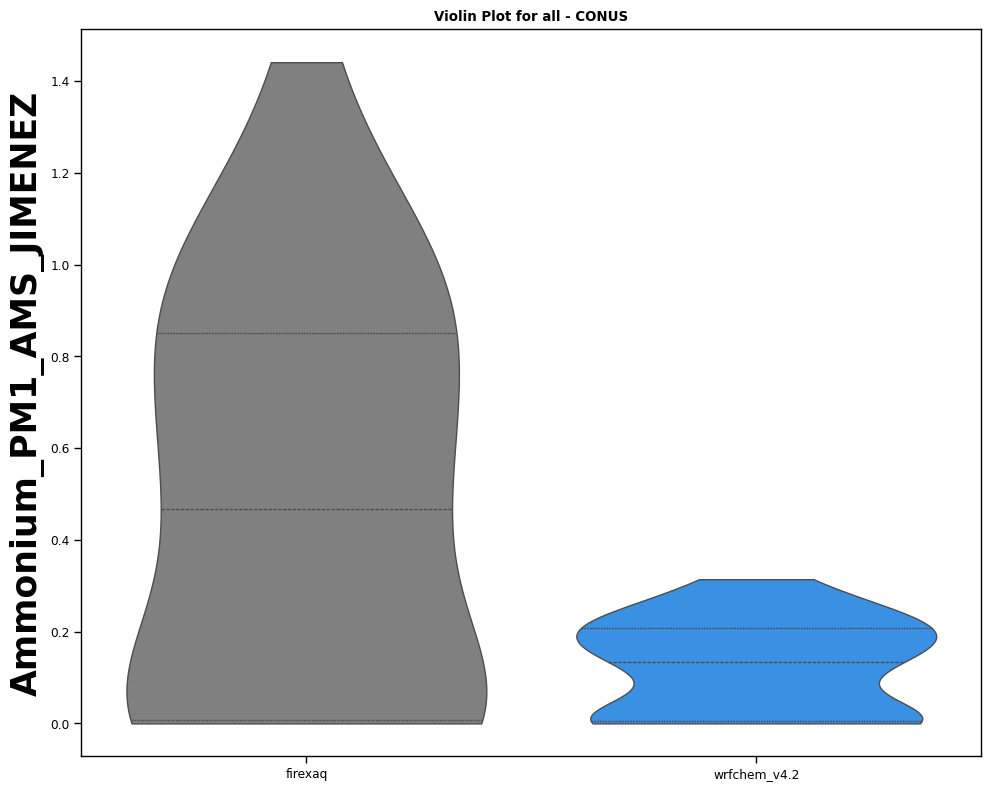

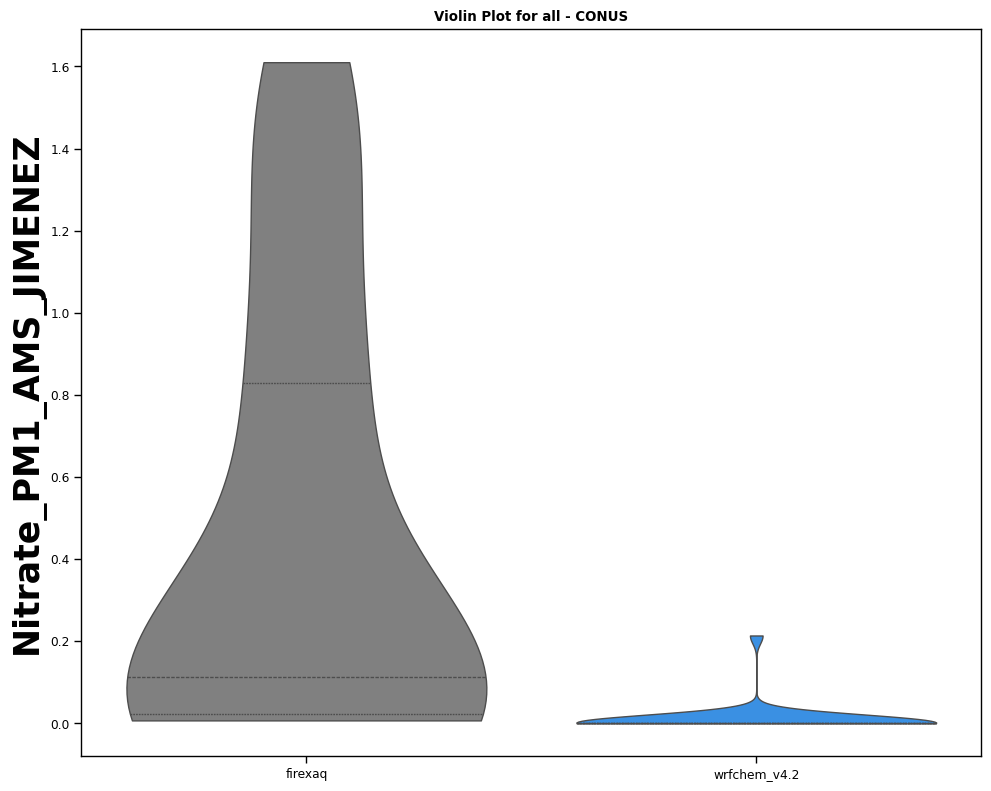

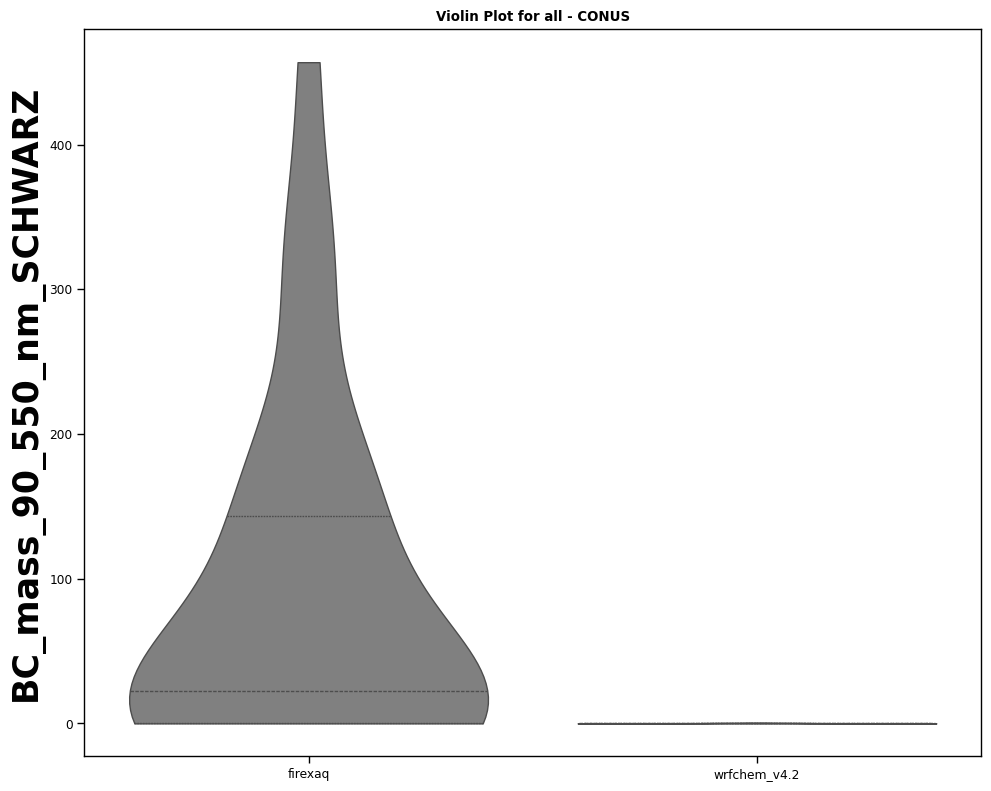

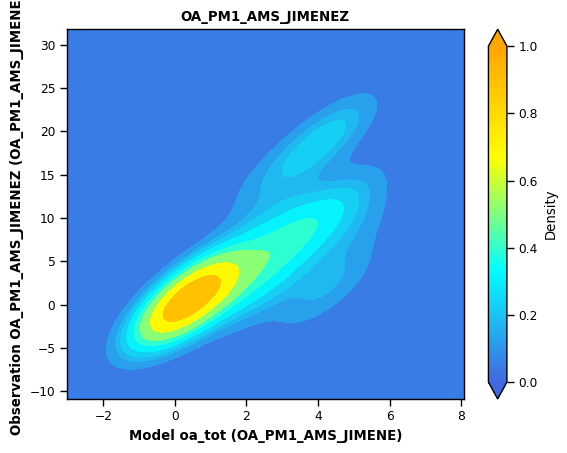

Saving scatter density plot to /wrk/charkins/melodies_monet/aircraft/develop_sumvars/output/plot_grp4.scatter_density.OA_PM1_AMS_JIMENEZ.2019-09-05_12.2019-09-06_00.all.CONUS_firexaq_vs_wrfchem_v4.2.png...
Value of fill after reading from scatter_density_config: True
Processing scatter density plot for model 'wrfchem_v4.2' and observation 'firexaq'...


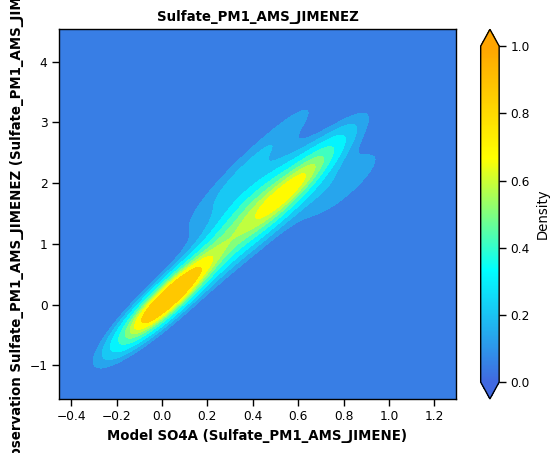

Saving scatter density plot to /wrk/charkins/melodies_monet/aircraft/develop_sumvars/output/plot_grp4.scatter_density.Sulfate_PM1_AMS_JIMENEZ.2019-09-05_12.2019-09-06_00.all.CONUS_firexaq_vs_wrfchem_v4.2.png...
Value of fill after reading from scatter_density_config: True
Processing scatter density plot for model 'wrfchem_v4.2' and observation 'firexaq'...


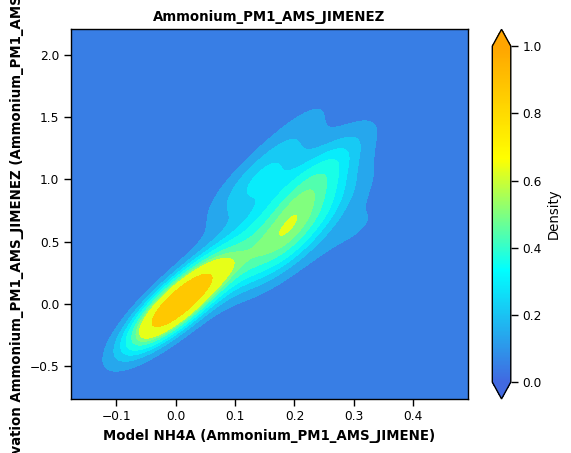

Saving scatter density plot to /wrk/charkins/melodies_monet/aircraft/develop_sumvars/output/plot_grp4.scatter_density.Ammonium_PM1_AMS_JIMENEZ.2019-09-05_12.2019-09-06_00.all.CONUS_firexaq_vs_wrfchem_v4.2.png...
Value of fill after reading from scatter_density_config: True
Processing scatter density plot for model 'wrfchem_v4.2' and observation 'firexaq'...


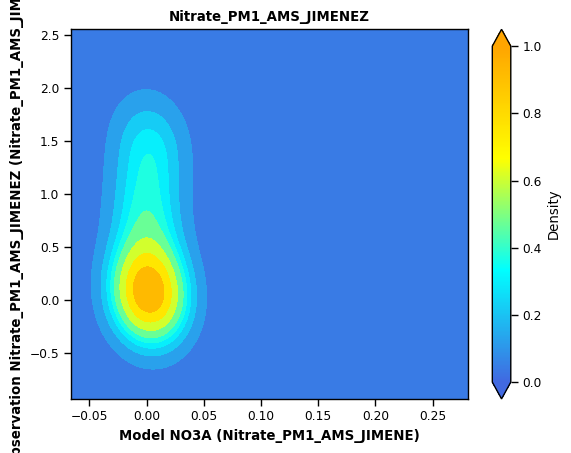

Saving scatter density plot to /wrk/charkins/melodies_monet/aircraft/develop_sumvars/output/plot_grp4.scatter_density.Nitrate_PM1_AMS_JIMENEZ.2019-09-05_12.2019-09-06_00.all.CONUS_firexaq_vs_wrfchem_v4.2.png...
Value of fill after reading from scatter_density_config: True
Processing scatter density plot for model 'wrfchem_v4.2' and observation 'firexaq'...


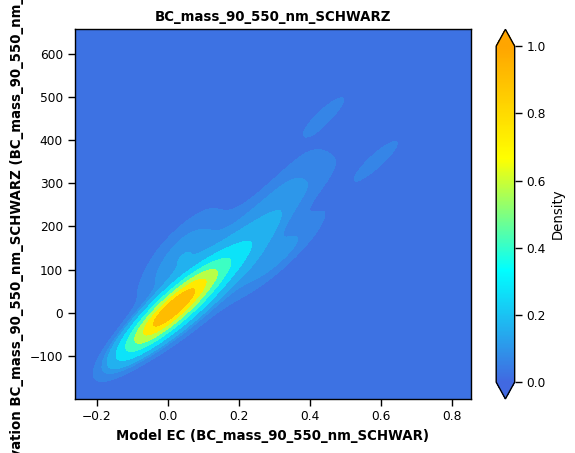

Saving scatter density plot to /wrk/charkins/melodies_monet/aircraft/develop_sumvars/output/plot_grp4.scatter_density.BC_mass_90_550_nm_SCHWARZ.2019-09-05_12.2019-09-06_00.all.CONUS_firexaq_vs_wrfchem_v4.2.png...
Reference std: 6.42159777341964
Reference std: 0.9375688589149742
Reference std: 0.4483533176345893
Reference std: 0.5552247560331568
Reference std: 119.86855744884247


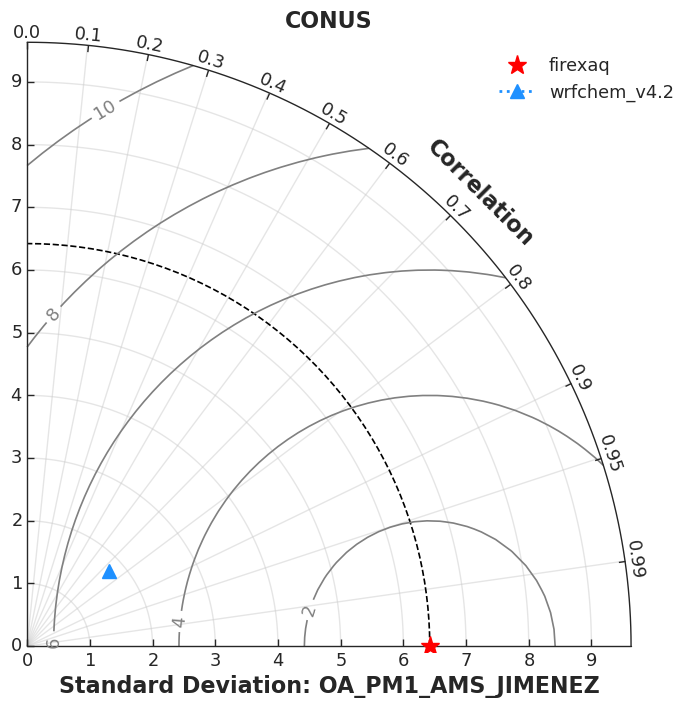

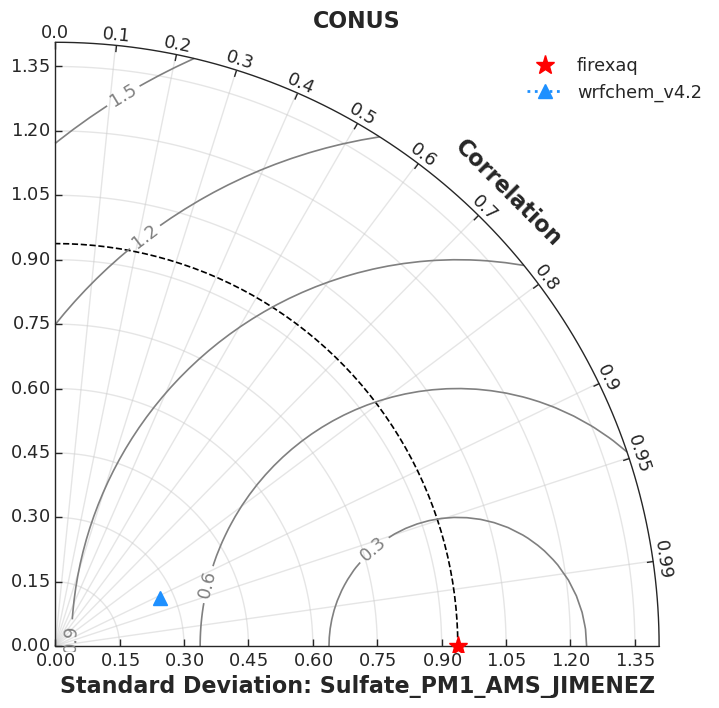

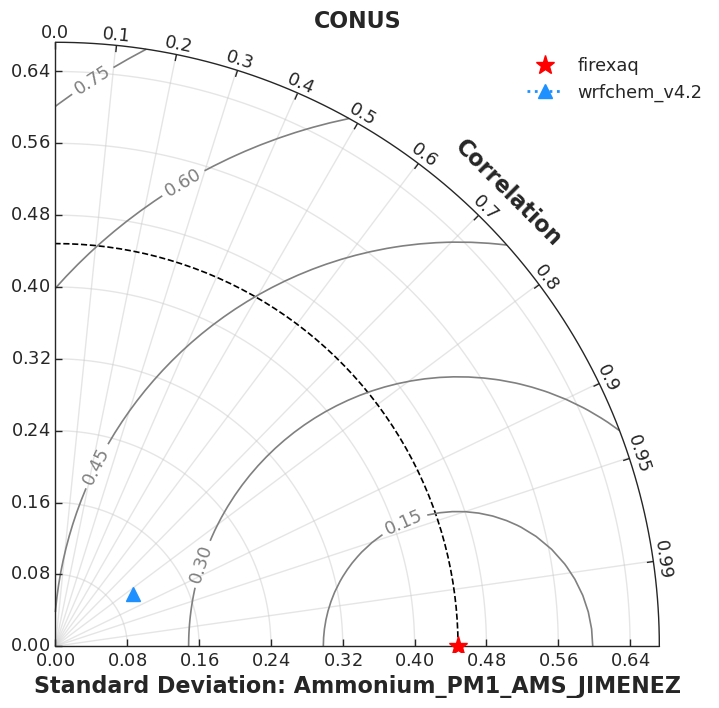

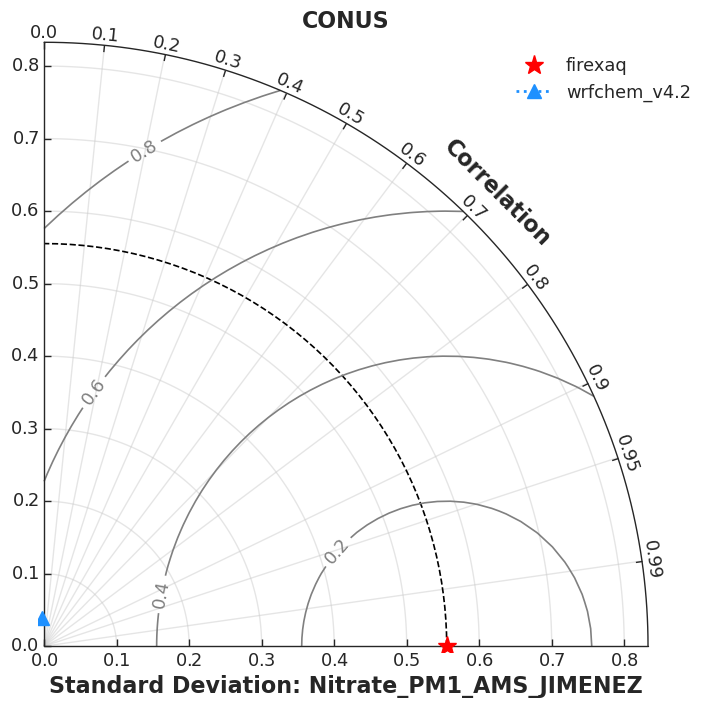

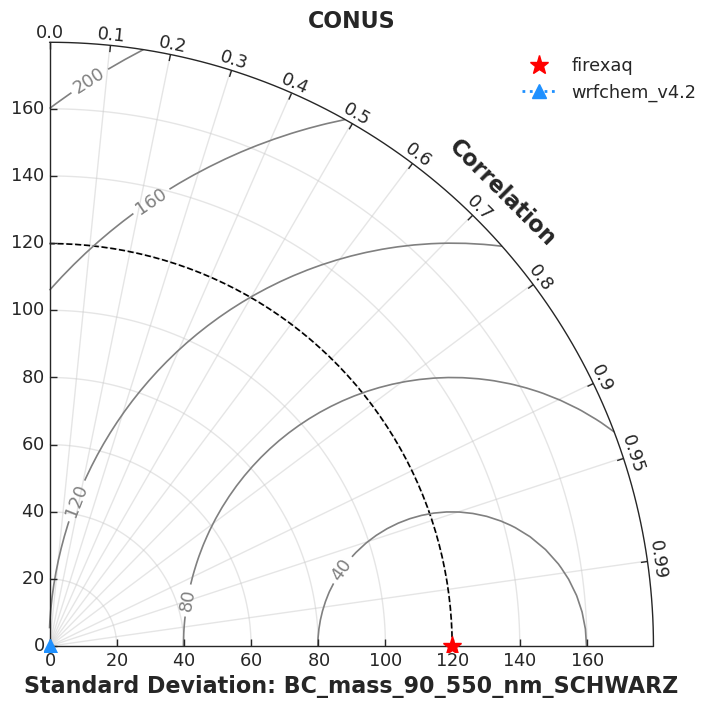

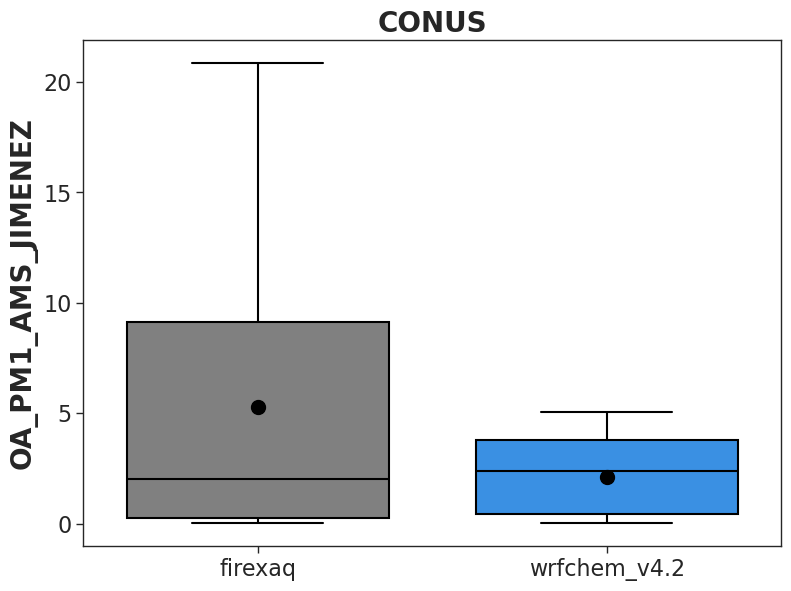

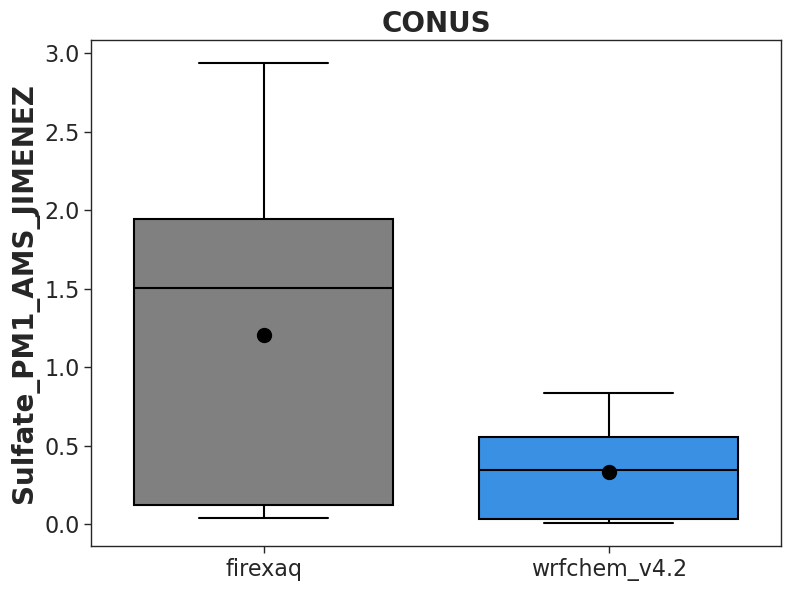

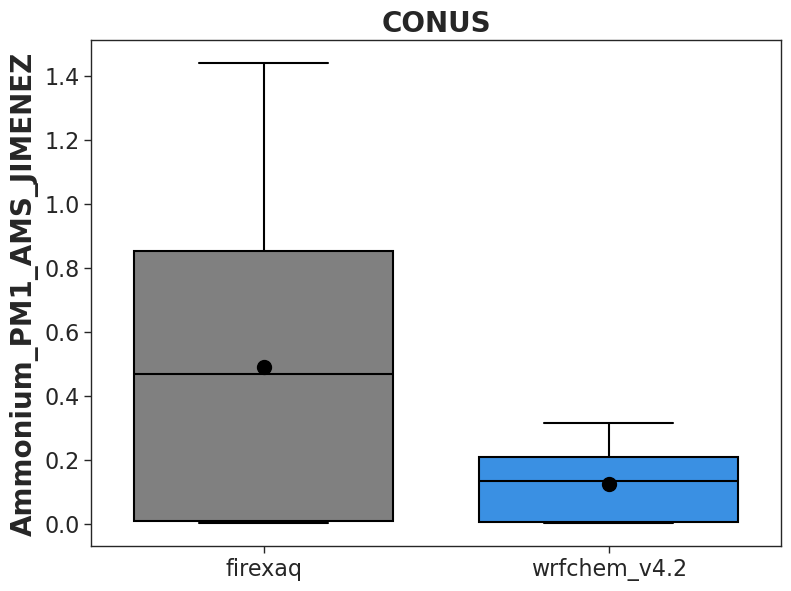

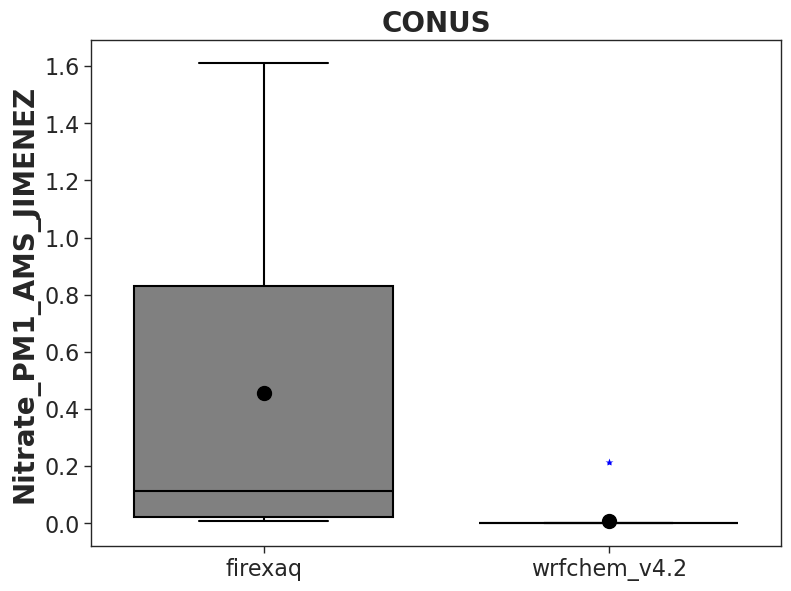

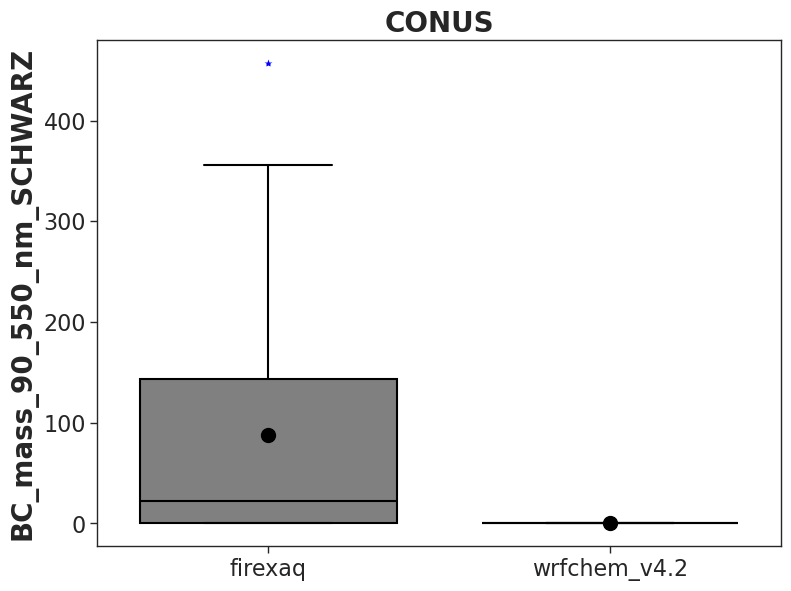

In [17]:
#And this generates all the plots.
an.plotting()

In [18]:
#Calculate stats
an.stats()  